In [1]:
"""
Changes from OHE3:
-We impute categorical NaN as -1(missing value category)
-We remove features with more than a 40% NaN(instead of 20%)
"""

'\nChanges from OHE2:\n-Here we do not drop features according to correlation with the target\n-We also try here lambda = 1e-7\n'

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from Data_cleaning import *
from helpers import *
from exploratory_data_analysis import *
from preprocessing import *

In [3]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data\dataset\dataset")

In [50]:
Y_tr = (y_train + 1) / 2

In [51]:
X_train, keep_mask = remove_nan_features(x_train, 0.4)
X_test = x_test[:, keep_mask]

In [52]:
print(X_train.shape, X_test.shape)

(328135, 163) (109379, 163)


In [53]:
cat_mask, num_mask = detect_categorical_features(X_train, max_unique=10)

In [54]:
print(np.sum(cat_mask), np.sum(num_mask))

102 61


In [55]:
x_tr, y_tr, x_va, y_va, x_te, y_te = stratified_three_way_split(X_train, Y_tr)

In [56]:
print(X_train.shape, x_tr.shape, y_tr.shape, x_va.shape, y_va.shape, x_te.shape, y_te.shape)

(328135, 163) (229695, 163) (229695,) (49220, 163) (49220,) (49220, 163) (49220,)


In [57]:
def impute_categorical_missing_code(X, cat_mask, missing_code=-1.0):
    """
    Replace NaNs in *categorical* columns with a special code (default -1),
    leaving numeric columns unchanged.

    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Full feature matrix (numeric + categorical).
    cat_mask : np.ndarray of bool, shape (n_features,)
        True for categorical columns, False for numeric ones.
    missing_code : float, default=-1.0
        Code used to represent 'Missing' category.

    Returns
    -------
    X_imputed : np.ndarray, same shape as X
        Copy of X where NaNs in categorical columns are replaced by `missing_code`.
    """
    Xf = np.array(X, dtype=np.float64, copy=True)
    cat_idx = np.where(cat_mask)[0]

    for j in cat_idx:
        col = Xf[:, j]
        nan_mask = np.isnan(col)
        if np.any(nan_mask):
            col[nan_mask] = missing_code
            Xf[:, j] = col

    return Xf


In [58]:
# Identify numerical features with at least one missing value in the training set
nan_counts = np.sum(np.isnan(x_tr[:, num_mask]), axis=0)
has_missing = nan_counts > 0
print(f"{np.sum(has_missing)} of {np.sum(num_mask)} numerical features have missing values.")

# Record missingness indicators only for those features
miss_tr = np.isnan(x_tr[:, num_mask][:, has_missing]).astype(float)
miss_va = np.isnan(x_va[:, num_mask][:, has_missing]).astype(float)
miss_te = np.isnan(x_te[:, num_mask][:, has_missing]).astype(float)
miss_test = np.isnan(X_test[:, num_mask][:, has_missing]).astype(float)

# Median imputation for numerical features (computed on training set)
x_tr_imp, medians = impute_numerical(x_tr, num_mask)
x_va_imp, _ = impute_numerical(x_va, num_mask, medians)
x_te_imp, _ = impute_numerical(x_te, num_mask, medians)
x_test_imp, _ = impute_numerical(X_test, num_mask, medians)

# Append the missingness indicator columns
x_tr_imp = np.concatenate([x_tr_imp, miss_tr], axis=1)
x_va_imp = np.concatenate([x_va_imp, miss_va], axis=1)
x_te_imp = np.concatenate([x_te_imp, miss_te], axis=1)
x_test_imp = np.concatenate([x_test_imp, miss_test], axis=1)


# Categorical imputation (add -1 to NaN)
x_tr_imp = impute_categorical_missing_code(x_tr_imp, cat_mask)
x_va_imp = impute_categorical_missing_code(x_va_imp, cat_mask)
x_te_imp = impute_categorical_missing_code(x_te_imp, cat_mask)
x_test_imp = impute_categorical_missing_code(x_test_imp, cat_mask)

42 of 61 numerical features have missing values.


In [59]:
# Check for any remaining NaN values
print(np.isnan(x_tr_imp).sum(),
      np.isnan(x_va_imp).sum(),
      np.isnan(x_te_imp).sum(), np.isnan(x_test_imp).sum())

0 0 0 0


In [60]:
# We'll clip at the 1st and 99th percentiles 
low_p, high_p = 1, 99

# Make copies to avoid modifying originals
x_tr_clip = x_tr_imp.copy()
x_va_clip = x_va_imp.copy()
x_te_clip = x_te_imp.copy()
x_test_clip = x_test_imp.copy()

# Apply clipping per numerical feature
for i in np.where(num_mask)[0]:
    low = np.nanpercentile(x_tr_imp[:, i], low_p)
    high = np.nanpercentile(x_tr_imp[:, i], high_p)

    x_tr_clip[:, i] = np.clip(x_tr_clip[:, i], low, high)
    x_va_clip[:, i] = np.clip(x_va_clip[:, i], low, high)
    x_te_clip[:, i] = np.clip(x_te_clip[:, i], low, high)
    x_test_clip[:, i] = np.clip(x_test_clip[:, i], low, high)


In [61]:
print(x_tr_clip.shape, x_va_clip.shape, x_te_clip.shape)


(229695, 205) (49220, 205) (49220, 205)


In [62]:
for i in np.where(num_mask)[0][:5]:  # first 5 numeric columns
    orig_min = np.nanmin(x_tr[:, i])
    orig_max = np.nanmax(x_tr[:, i])
    clip_min = np.min(x_tr_clip[:, i])
    clip_max = np.max(x_tr_clip[:, i])
    print(f"Feature {i}: before [{orig_min:.2f}, {orig_max:.2f}], after [{clip_min:.2f}, {clip_max:.2f}]")


Feature 0: before [1.00, 72.00], after [1.00, 72.00]
Feature 1: before [1.00, 12.00], after [1.00, 12.00]
Feature 2: before [1012016.00, 12312015.00], after [1072016.00, 12232015.00]
Feature 3: before [1.00, 12.00], after [1.00, 12.00]
Feature 4: before [1.00, 31.00], after [1.00, 31.00]


In [63]:
date_col_idx = 2  # the column that represents the interview date

# 1. Drop the column from all datasets
x_train_nodate = np.delete(x_tr_clip, date_col_idx, axis=1)
x_valid_nodate = np.delete(x_va_clip, date_col_idx, axis=1)
x_te_nodate  = np.delete(x_te_clip, date_col_idx, axis=1)
x_test_nodate = np.delete(x_test_clip, date_col_idx, axis=1)

# 2. Drop the same index from masks
num_mask_nodate = np.delete(num_mask, date_col_idx)
cat_mask_nodate = np.delete(cat_mask, date_col_idx)

# 3. Sanity check
print("Train shape before:", x_tr_clip.shape, "after:", x_train_nodate.shape)
print("Numeric features:", np.sum(num_mask_nodate))
print("Categorical features:", np.sum(cat_mask_nodate))


Train shape before: (229695, 205) after: (229695, 204)
Numeric features: 60
Categorical features: 102


In [64]:
new_cat_mask, new_num_mask = detect_categorical_features(x_train_nodate, max_unique=10)

In [65]:
print(np.sum(new_num_mask), np.sum(new_cat_mask))

60 144


In [66]:
x_tr_std, means, stds = standardize_features(x_train_nodate, new_num_mask)
x_va_std, _, _ = standardize_features(x_valid_nodate, new_num_mask, means, stds)
x_te_std, _, _ = standardize_features(x_te_nodate, new_num_mask, means, stds)
x_test_std, _, _ = standardize_features(x_test_nodate, new_num_mask, means, stds)

In [67]:
means_check = np.mean(x_tr_std[:, new_num_mask], axis=0)
stds_check  = np.std(x_tr_std[:, new_num_mask], axis=0)

print("Mean range:", np.min(means_check), "to", np.max(means_check))
print("Std range:", np.min(stds_check), "to", np.max(stds_check))


Mean range: -1.0562167731031524e-15 to 6.296420186646123e-11
Std range: 0.9999999999999998 to 1.0000000000000002


In [75]:
# Fit one-hot encoder on training data
x_tr_enc, categories = one_hot_encode(x_tr_std, new_cat_mask, drop_first=True)

# Apply the same categories to validation and test data
x_va_enc, _ = one_hot_encode(x_va_std, new_cat_mask, categories, drop_first=True)
x_te_enc, _ = one_hot_encode(x_te_std, new_cat_mask, categories, drop_first=True)
x_test_enc, _ = one_hot_encode(x_test_std, new_cat_mask, categories, drop_first=True)

In [76]:
print(x_tr_enc.shape, x_va_enc.shape, x_te_enc.shape, x_test_enc.shape) 

(229695, 465) (49220, 465) (49220, 465) (109379, 465)


In [77]:
# Verify no NaNs or infinities
print(np.isnan(x_tr_enc).sum(), np.isfinite(x_tr_enc).all())

# Verify numeric ranges are reasonable
print(np.min(x_tr_enc), np.max(x_tr_enc))

# Check label balance
unique, counts = np.unique(y_tr, return_counts=True)
print(dict(zip(unique, counts)))


0 True
-2.977473718717645 9.047045642411586
{np.float64(0.0): np.int64(209412), np.float64(1.0): np.int64(20283)}


In [88]:
cat_mask_enc, num_mask_enc = detect_categorical_features(x_tr_enc, max_unique=10)

In [89]:
print(np.sum(cat_mask_enc), np.sum(num_mask_enc))

405 60


In [90]:
print(np.max(x_tr_enc[:,cat_mask_enc]))

1.0


In [ ]:
best_params, best_f1, results = grid_search(
    y_tr, x_tr_enc,
    y_va, x_va_enc,
    pos_weights=[9.5, 10, 10.5],
    lambdas=[1e-3, 1e-4],
    thresholds=np.linspace(0.5, 0.9, 400),
    max_iter=10000,
    gamma=0.5
)



=== Run 1/6 (pos_weight=9.5, lambda_=0.001) ===


In [38]:
X_final = np.vstack([x_tr_final, x_va_final])
y_final = np.concatenate([y_tr, y_va])


In [39]:
best_lambda = 1e-8
best_pos_weight = 6.5
best_neg_weight = 1.0
best_threshold = 0.7476190476190476

final_loss, w_final = logistic_regression_weighted_gd(
    y_final, X_final,
    lambda_=best_lambda,
    gamma=0.5,
    pos_weight=best_pos_weight,
    neg_weight=best_neg_weight,
    max_iter=10000,
    verbose=True
)

print("Final training loss:", final_loss)


Iter     0 | Loss = 0.693147 | GradNorm = 0.7272
Iter   100 | Loss = 0.497236 | GradNorm = 0.5773
Iter   200 | Loss = 0.483206 | GradNorm = 0.4983
Iter   300 | Loss = 0.477520 | GradNorm = 0.4592
Iter   400 | Loss = 0.474594 | GradNorm = 0.4368
Iter   500 | Loss = 0.472920 | GradNorm = 0.4232
Iter   600 | Loss = 0.471888 | GradNorm = 0.4146
Iter   700 | Loss = 0.471212 | GradNorm = 0.4089
Iter   800 | Loss = 0.470744 | GradNorm = 0.4051
Iter   900 | Loss = 0.470403 | GradNorm = 0.4023
Iter  1000 | Loss = 0.470143 | GradNorm = 0.4002
Iter  1100 | Loss = 0.469936 | GradNorm = 0.3986
Iter  1200 | Loss = 0.469766 | GradNorm = 0.3973
Iter  1300 | Loss = 0.469623 | GradNorm = 0.3962
Iter  1400 | Loss = 0.469498 | GradNorm = 0.3952
Iter  1500 | Loss = 0.469389 | GradNorm = 0.3944
Iter  1600 | Loss = 0.469291 | GradNorm = 0.3937
Iter  1700 | Loss = 0.469202 | GradNorm = 0.3930
Iter  1800 | Loss = 0.469121 | GradNorm = 0.3924
Iter  1900 | Loss = 0.469046 | GradNorm = 0.3918
Iter  2000 | Loss = 

In [40]:
print(w_final @ w_final)

9.69559881779544


In [41]:
acc, f1 = evaluate_model(y_te, x_te_final, w_final, best_threshold)

 Accuracy: 87.34%
 F1 Score: 0.4246


Confusion Matrix:
[[40690  4184]
 [ 2047  2299]]
TN=40690, FP=4184, FN=2047, TP=2299


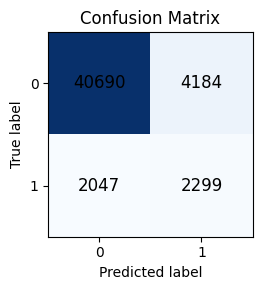

In [42]:
preds, _ = predict_with_threshold(x_te_final, w_final, threshold=best_threshold)
cm = confusion_matrix_numpy(y_te, preds)

In [44]:
y_pred_final, _ = predict_with_threshold(x_test_final, w_final, best_threshold)
y_pred_final = 2 * y_pred_final - 1   # converts 0→-1, 1→1

create_csv_submission(test_ids, y_pred_final, "ModelOHE3MVNC_preds.csv")